# Unsupervised Modeling of Synthetic Datasets

First we import the dataset and plot the `f1` and `f2` values as the x and y values respectively on a scatterplot to examine the distribution of the data points.

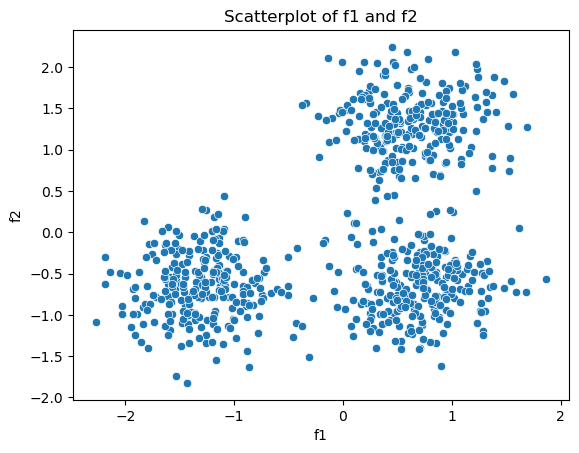

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("data/clustering_synthetic_dataset.csv")

sns.scatterplot(df, x='f1', y='f2')
plt.title("Scatterplot of f1 and f2")
plt.show()

There seems to be three species in this dataset, clustered spatially in the bottom right, upper right, and bottom left corners.

We can get an approximate idea of the feature ranges for each of the three groups by categorizing each point into one of three groups depending on their `f1` and `f2` values. To visualize this, we will generate a copy of the original dataframe and add an additional feature categorizing each point as a part of one of three groups, then plot the points with their colors to distinguish each cluster.

Based on the distribution of the points as seen in the scatterplot before, the three groups I will define will see if the point's `f2` value is less than 0.5. If it is not, then it is a part of group C. Then I examine if the point's `f1` value is greater than 0. If it not, then it is a part of group B. Every other point will be in group A. This is a basic example of a rule-based decision making model.

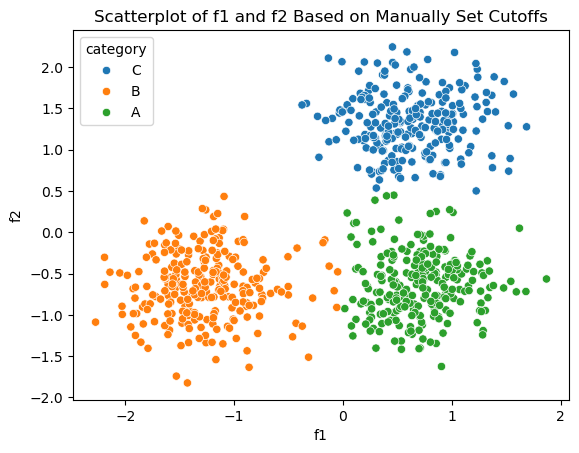

In [2]:
df_color = df.copy()

def categorize_point(row):
    if row['f2'] < 0.5:
        if row['f1'] > 0:
            return 'A'
        return 'B'
    return 'C'

df_color['category'] = df_color.apply(categorize_point, axis=1)

sns.scatterplot(df_color, x='f1', y='f2', hue='category', palette='tab10')
plt.title("Scatterplot of f1 and f2 Based on Manually Set Cutoffs")
plt.show()

Using specified values for the cutoff seems to classify the datapoints fine, but there are some instances where the classification can be a bit questionable. For example, there are a couple of points between clusters A and B that look closer to the cluster centroid of cluster A than cluster B, but are classified in cluster B with the preset cutoffs. We can improve upon the clustering method by using KMeans clustering.

We will perform K-means clustering of the points with K=3, since that is the number of clusters we assume there are in the original plot. We could use some established methods to determine the number of clusters to use (e.g. Elbow method, silhouette score, etc.) but this dataset seems to have rather well defined clusters for the most part, generated around 3 centroids.

Once we perform K-means clustering of the points we can also store the centroid points for each of the clusters in its own dataframe. These will be used later to calculate the euclidean distance between the data points and the centroids each one is respectively classified in.

In [3]:
from sklearn.cluster import KMeans

K = 3

km = KMeans(n_clusters=K, init='random', random_state=42)
df['cluster'] = km.fit_predict(df)

cluster_centroids = pd.DataFrame(km.cluster_centers_, columns=['f1_centroid', 'f2_centroid'])

cluster_centroids

,f1_centroid,f2_centroid
0,0.622606,1.317260
1,0.695459,-0.644423
2,-1.302662,-0.657042


We can now plot the points colored to represent the cluster they are classified in and represent the centroids of each cluster as a red X.

Cluster Centers with Cluster Group as Index:

   f1_centroid  f2_centroid
0     0.622606     1.317260
1     0.695459    -0.644423
2    -1.302662    -0.657042


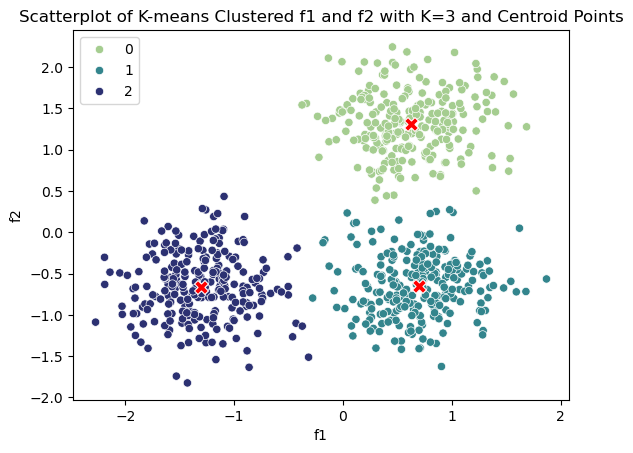

In [4]:
fig, ax = plt.subplots()

sns.scatterplot(df, x='f1', y='f2', hue='cluster', palette='crest', ax=ax)
sns.scatterplot(cluster_centroids, x='f1_centroid', y='f2_centroid', s=100, marker="X", c='r', ax=ax)

print(f"Cluster Centers with Cluster Group as Index:\n\n{cluster_centroids[['f1_centroid', 'f2_centroid']]}") 

plt.title("Scatterplot of K-means Clustered f1 and f2 with K=3 and Centroid Points")

plt.show()

Now that we have the cluster centers we can calculate the euclidean distance between all points and their respective centroids and add it to a new column.

In [5]:
cluster_centroids = cluster_centroids.reset_index().rename(columns={'index':'cluster'})
df = df.merge(cluster_centroids, on='cluster')

#euclidean distance
df['distance_from_centroid'] = np.sqrt((df['f1'] - df['f1_centroid'])**2 + (df['f2'] - df['f2_centroid'])**2) 

df.head()

,f1,f2,cluster,f1_centroid,f2_centroid,distance_from_centroid
0,0.494261,1.451067,0,0.622606,1.317260,0.185410
1,-1.428081,-0.837064,2,-1.302662,-0.657042,0.219403
2,0.338559,1.038759,0,0.622606,1.317260,0.397800
3,0.119001,-1.053976,1,0.695459,-0.644423,0.707133
4,1.122425,1.774937,0,0.622606,1.317260,0.677707


We can visualize the outliers in our unsupervised classification using a boxplot. Points outside the minimum and maximum extreme will be considered outliers. More rigorously, any data point having a euclidean distance to the cluster centroid greater than 1.5 * IQR below the first quartile or 1.5 * IQR above the third quartile will be considered an outlier.

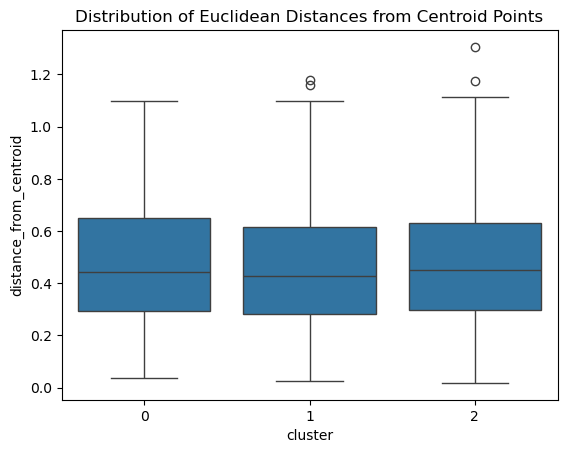

In [6]:
sns.boxplot(df, x='cluster', y='distance_from_centroid')
plt.title("Distribution of Euclidean Distances from Centroid Points")
plt.show()

It seems that there are only four outlier points in this dataset, two in cluster 1 and two in cluster 2. Let us find them by sorting by the `distance_from_centroid` feature.

In [7]:
df.sort_values(by='distance_from_centroid', ascending=False).head()

,f1,f2,cluster,f1_centroid,f2_centroid,distance_from_centroid
461,-0.316450,-1.512189,2,-1.302662,-0.657042,1.305332
663,1.870438,-0.564764,1,0.695459,-0.644423,1.177677
16,-1.430208,-1.823801,2,-1.302662,-0.657042,1.173709
273,1.621982,0.050201,1,0.695459,-0.644423,1.157994
570,-1.093526,0.435205,2,-1.302662,-0.657042,1.112088


The first four values are the ones which contain the outliers, since these are the four values with the greatest distance from the centroid. Let us visualize where these points are on our scatterplot.

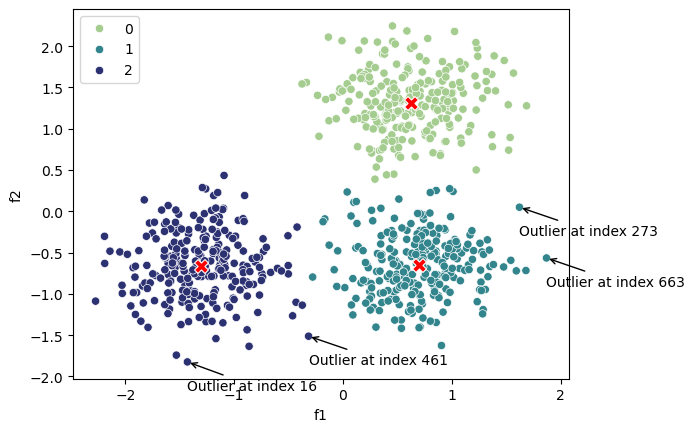

In [8]:
outlier_points = df.sort_values(by='distance_from_centroid', ascending=False)[:4]

fig, ax = plt.subplots()

sns.scatterplot(df, x='f1', y='f2', hue='cluster', palette='crest', ax=ax)
sns.scatterplot(cluster_centroids, x='f1_centroid', y='f2_centroid', s=100, marker="X", c='r', ax=ax)

for index in outlier_points.index:
    plt.annotate(
        f"Outlier at index {index}",
        (df.loc[index, 'f1'], df.loc[index, 'f2']),
        textcoords="offset points",
        xytext=(0,-20),
        arrowprops=dict(arrowstyle="->", lw=1)
    )

plt.show()

It does seem that these points are further from the centroid than the other points are. If we were to broaden the definition of an outlier, there would probably be more points classified as outliers for all centroids.

## Using DBSCAN to Determine Outliers in Dataset

We can also use DBSCAN to find anomalies in the dataset. We will predict the cluster which the points belong to using a DBSCAN and assign the predictions with the original points to a new dataframe.

In [13]:
from sklearn.cluster import DBSCAN

def make_dbscan_prediction(df:pd.DataFrame, eps=0.2, min_samples=10):

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
    labels = db.labels_

    dbscan_df = df.copy().drop(columns=['f1_centroid', 'f2_centroid', 'distance_from_centroid', 'cluster'])
    dbscan_df['dbscan_predictions'] = labels

    return dbscan_df, labels

dbscan_df, labels = make_dbscan_prediction(df, 0.2, 10)

dbscan_df.head()

,f1,f2,dbscan_predictions
0,0.494261,1.451067,0
1,-1.428081,-0.837064,1
2,0.338559,1.038759,0
3,0.119001,-1.053976,2
4,1.122425,1.774937,-1


The value of the parameter `eps=` determines the maximum distance for two samples to be considered in the neighborhood of each other. Larger values for `eps` results in less points being labeled as noise around the clusters whereas smaller values for `eps` results in more points being labeled as noise and potentially more groups to be classified in.

Let's have a look at the estimated number of clusters in our model and the number of points classified as noise.

In [10]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

Estimated number of clusters: 3
Estimated number of noise points: 175


This is quite a substantial number of points labeled as outliers, and is probably a result of the `eps` we set. We will keep this for now, however, and visualize the clusters the algorithm determined on a scatterplot.

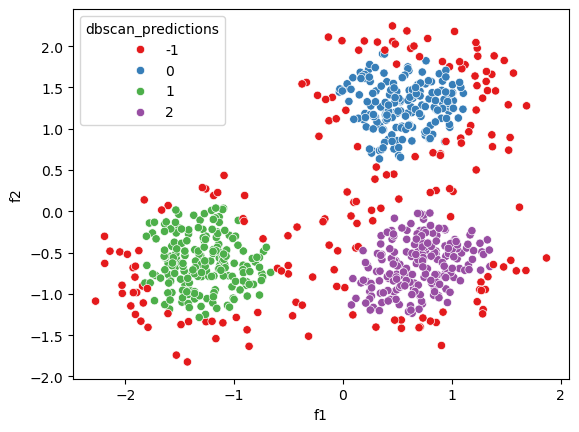

In [11]:

dbscan_outliers = dbscan_df.sort_values(by='dbscan_predictions')[:n_noise_]

sns.scatterplot(dbscan_df, x='f1', y='f2', hue='dbscan_predictions', palette='Set1')

plt.show()

The red points represent the points which the DBSCAN clustering algorithm determined to be noise. As we can see most of the points are concentrated to the outer edges of each of the clusters. Let's visualize the impact of changing eps across some values:

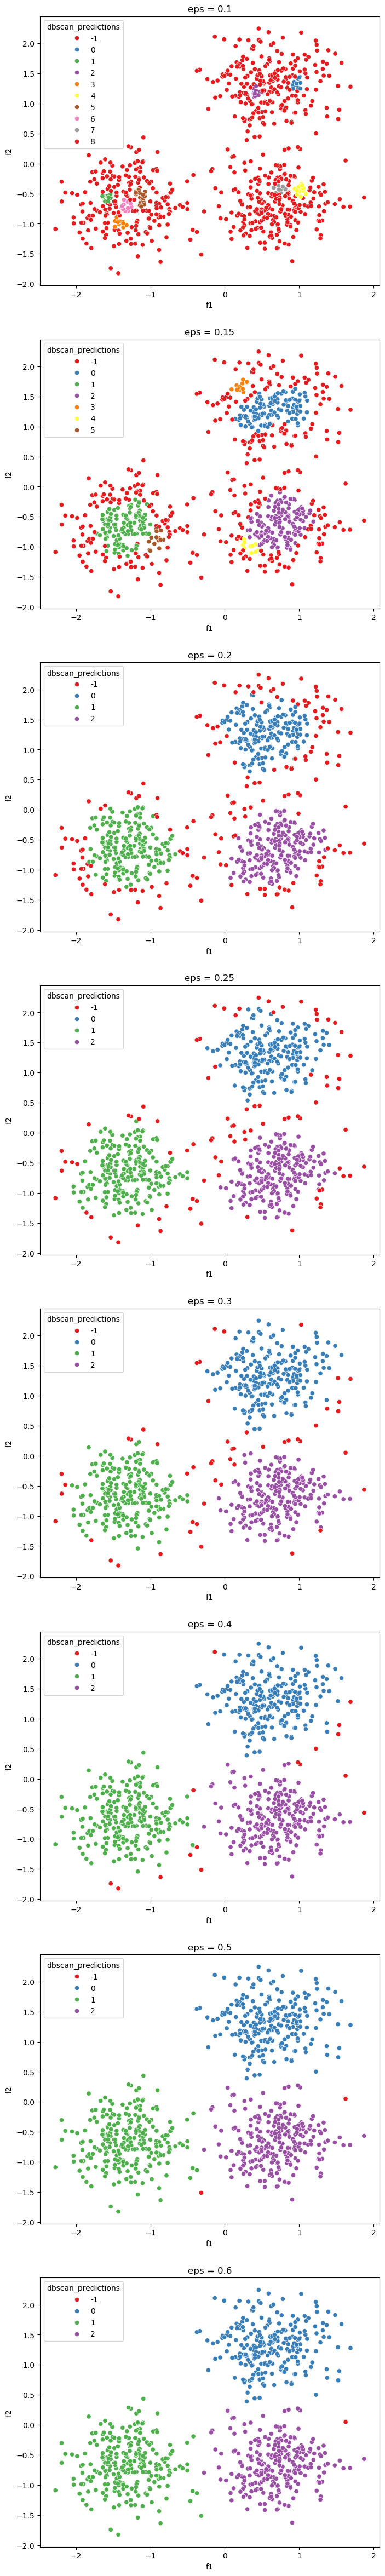

In [16]:
eps = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]

fig, ax = plt.subplots(len(eps))
fig.set_size_inches(8,60)

for i, val in enumerate(eps):
    dbscan_df, labels = make_dbscan_prediction(df, eps=val, min_samples=10)
    sns.scatterplot(dbscan_df, x='f1', y='f2', hue='dbscan_predictions', palette='Set1', ax=ax[i])
    ax[i].set_title(f"eps = {val}")

plt.show()

Clearly setting the correct value for the `eps` is crucial in determining which points belong to which groups. Generally larger values for `eps` result in less outliers for this dataset.

We will create a decision tree classifier to predict the class a data point belongs to in a modified slice of the dataset which does not contain the outliers and evaluate the accuracy of this model.

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

dbscan_without_outliers = dbscan_df.sort_values(by='dbscan_predictions')[n_noise_:]

dt = DecisionTreeClassifier()

X = dbscan_without_outliers.drop(columns=['dbscan_predictions'])
Y = dbscan_without_outliers['dbscan_predictions']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=42)

dt.fit(X_train, Y_train)
Y_pred = dt.predict(X_test)

Evalution of model accuracy using confusion matrix

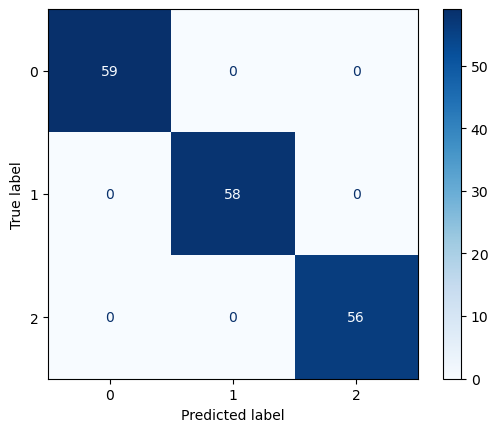

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(Y_test, Y_pred, labels=dt.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=dt.classes_,
)

disp.plot(
    cmap='Blues'
)

plt.show()

It seems that the default sklearn decision tree model was able to correctly predict the class a point was in given its coordinates 100% of the time when the 175 anomalies were removed from the dataset. How does the decision tree look? Let us display the decision tree the model generated.

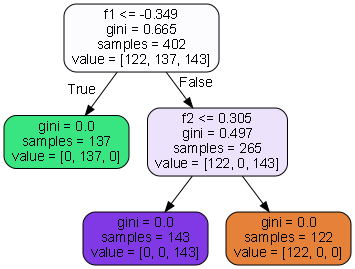

In [42]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import run

dot_data = export_graphviz(
    decision_tree=dt,
    out_file="decisiontree.dot",
    feature_names=X.columns,
    filled=True,
    rounded=True
)

run(['dot', '-Tpng', 'decisiontree.dot', '-o', 'decisiontree.png', '-Gdpi=72'], shell=True)

Image(filename="decisiontree.png")

It seems that the decision tree was able to generate a pretty simple decision model based on the input data, which was able to predict the values with 100% accuracy.

Now we can compare the performance of the model on the dataset containing the outliers and the dataset with the outliers removed.

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

dt_full = DecisionTreeClassifier()
dt_removed_outliers = DecisionTreeClassifier()

X_full_set = dbscan_df.drop(columns=['dbscan_predictions'])
Y_full_set = dbscan_df['dbscan_predictions']

def evaluate_classifier(_clf, _X : pd.DataFrame, _Y : pd.DataFrame):
    accuracies = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
    for train_index, test_index in kf.split(_X, _Y):
        _clf.fit(_X.loc[_X.index[train_index]], _Y.loc[_Y.index[train_index]])
        Y_pred = _clf.predict(_X.loc[_X.index[test_index]])
        accuracies.append(accuracy_score(_Y.loc[_Y.index[test_index]], Y_pred))
    return np.array(accuracies)

In [44]:
full_set_accuracies = evaluate_classifier(dt_full, X_full_set, Y_full_set)
removed_outlier_accuracies = evaluate_classifier(dt_removed_outliers, X, Y)

print(f"Average accuracy of 10 fold cross validated datasets for dataset with anomalies removed: {np.mean(removed_outlier_accuracies)}")
print(f"Average accuracy of 10 fold cross validated datasets for dataset with anomalies: {np.mean(full_set_accuracies)}")

Average accuracy of 10 fold cross validated datasets for dataset with anomalies removed: 1.0
Average accuracy of 10 fold cross validated datasets for dataset with anomalies: 0.9413333333333332


We can also display the decision trees for each model.

In [45]:
dot_dt_full = export_graphviz(
    decision_tree=dt_full,
    out_file="full_dataset_decisiontree.dot",
    feature_names=X.columns,
    filled=True,
    rounded=True
)

dot_dt_removed_outliers = export_graphviz(
    decision_tree=dt_removed_outliers,
    out_file="outlier_removed_decisiontree.dot",
    feature_names=X.columns,
    filled=True,
    rounded=True
)

run(['dot', '-Tpng', 'full_dataset_decisiontree.dot', '-o', 'full_dataset_decisiontree.png', '-Gdpi=72'], shell=True)
run(['dot', '-Tpng', 'outlier_removed_decisiontree.dot', '-o', 'outlier_removed_decisiontree.png', '-Gdpi=72'], shell=True)


CompletedProcess(args=['dot', '-Tpng', 'outlier_removed_decisiontree.dot', '-o', 'outlier_removed_decisiontree.png', '-Gdpi=72'], returncode=0)

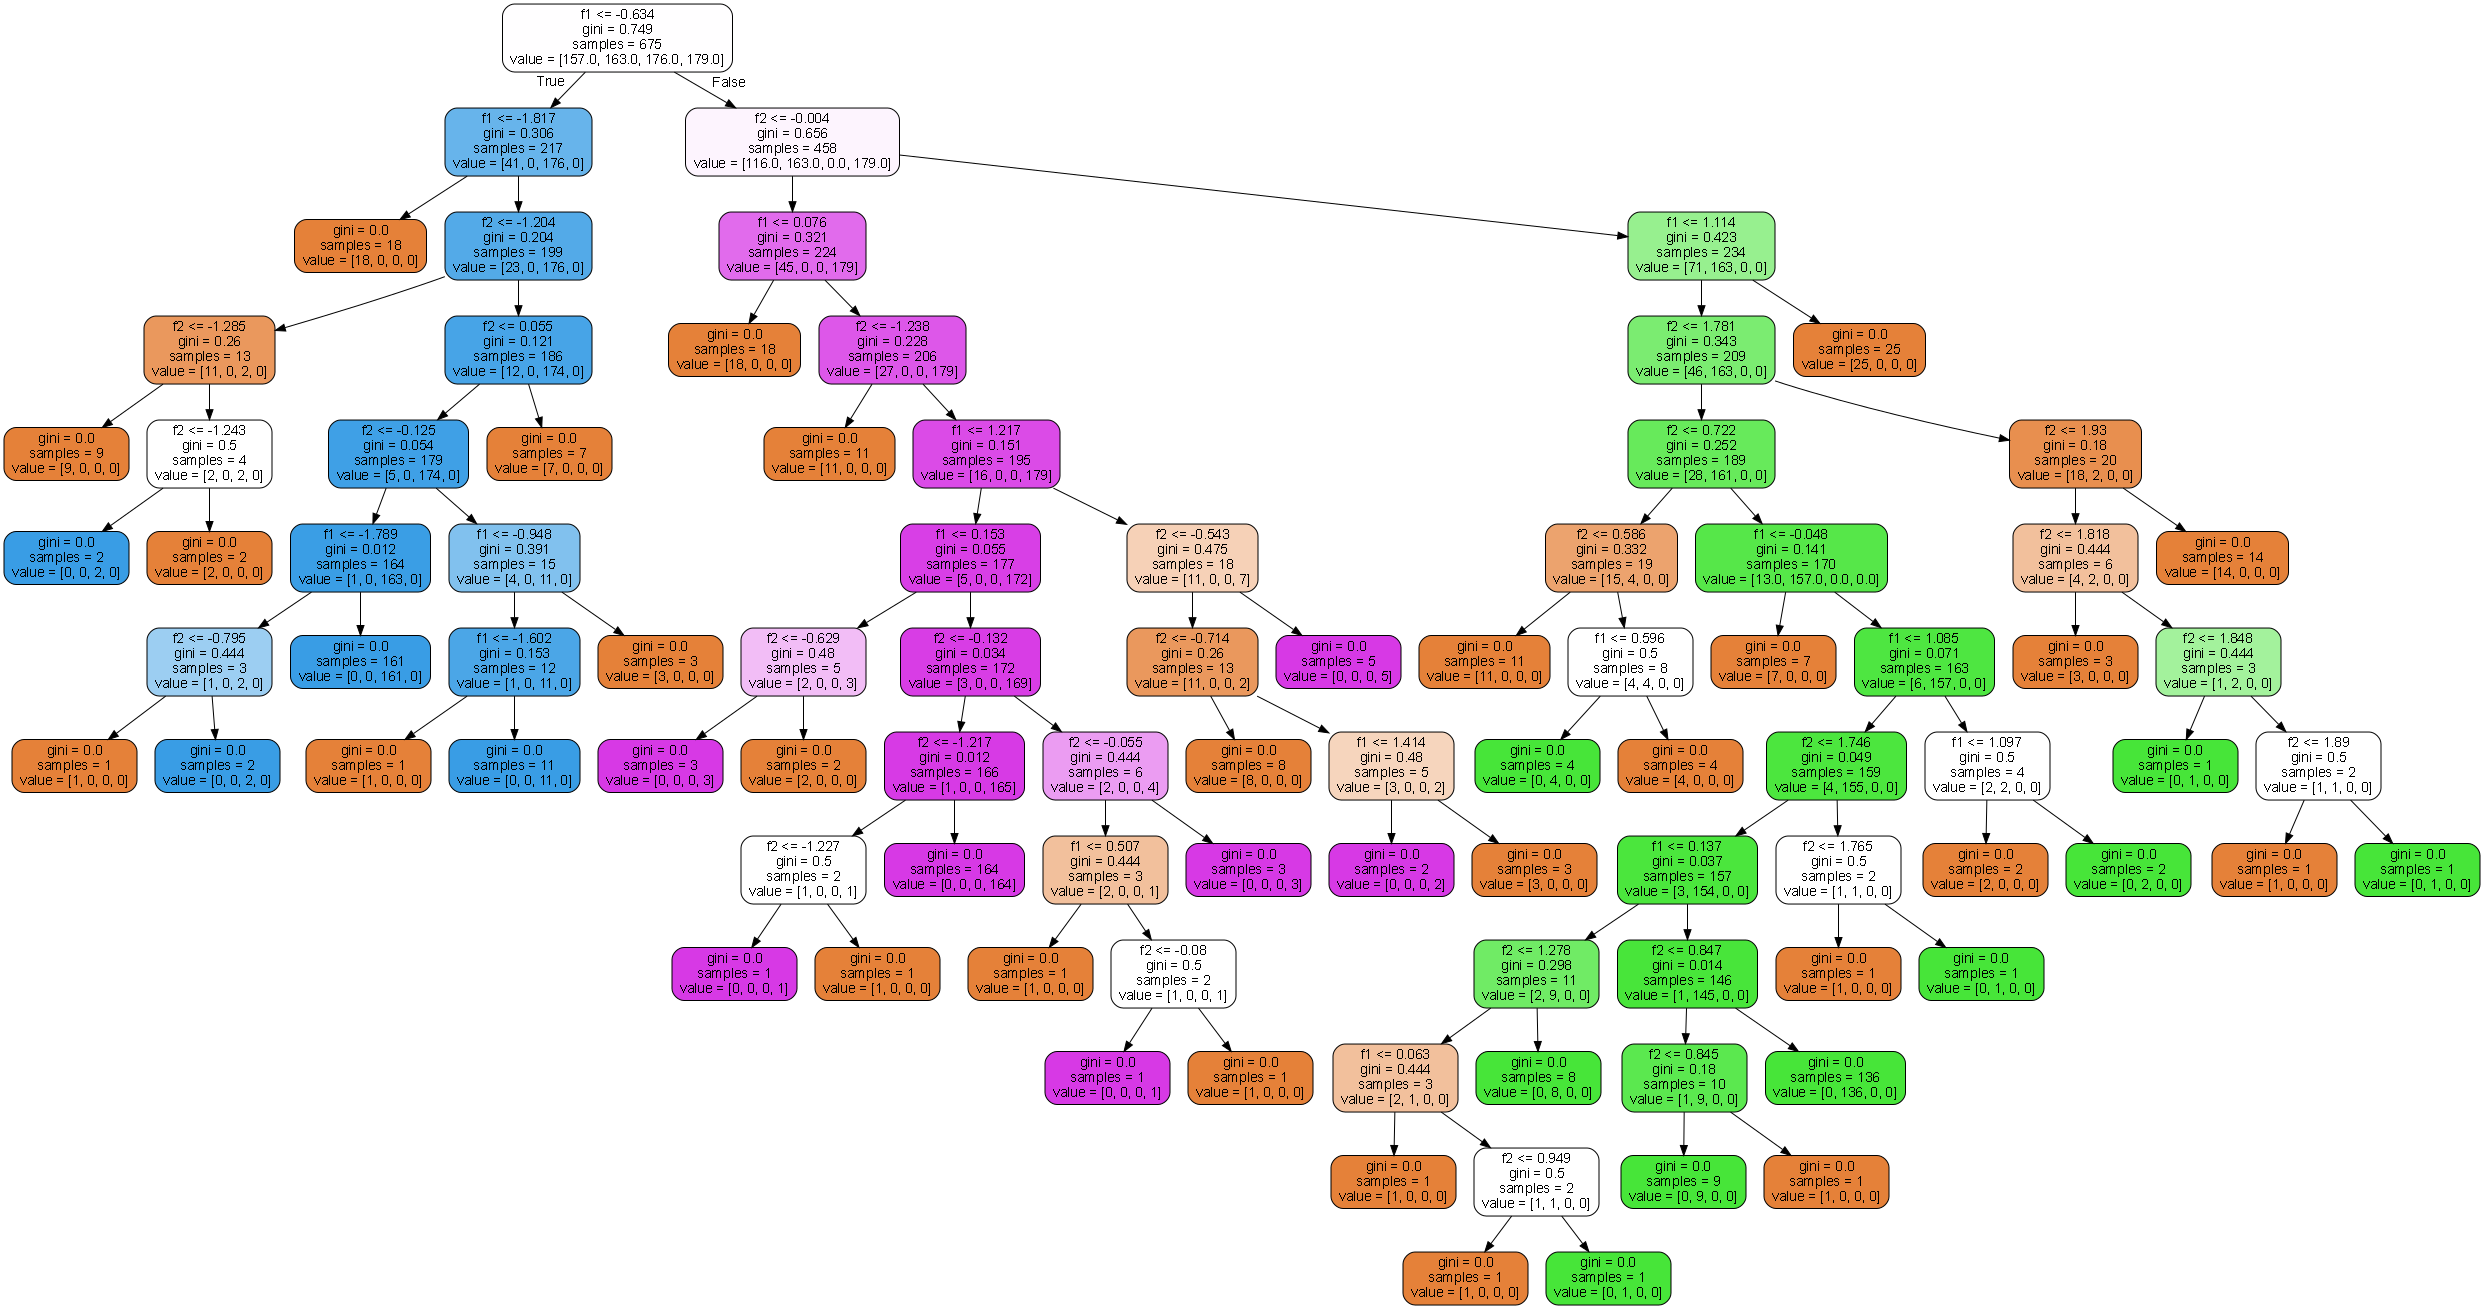

In [46]:
Image(filename="full_dataset_decisiontree.png")

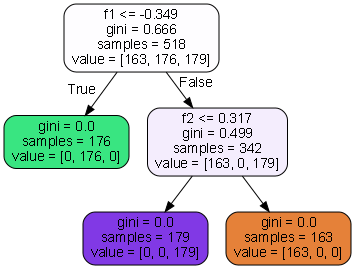

In [47]:
Image(filename="outlier_removed_decisiontree.png")

The depth of the decision tree for the full dataset is much more than the ones with the outliers removed.